## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,HalvingRandomSearchCV

import warnings
warnings.filterwarnings('ignore')

nlp = spacy.load('en_core_web_sm')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = "complaints-2021-05-14_08_16.json"# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
with open(f, "r") as content:
    data = json.loads(content.read())
df=pd.json_normalize(data)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

print('Shape of data =', df.shape)

Shape of data = (78313, 22)


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response', 'sub_product', 'timely',
       'complaint', 'sub_issue', 'consumer_consent_provided']
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaint',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign nan in place of blanks in the complaints column
print('Number of records with complaint as blanks =',df[df['complaint'] == ''].shape[0])
df['complaint'].replace('', np.NaN, inplace=True)
print('After replacing blank with Nan, number of records with complaint as blanks =',df[df['complaint'] == ''].shape[0])

Number of records with complaint as blanks = 57241
After replacing blank with Nan, number of records with complaint as blanks = 0


In [7]:
#Remove all rows where complaints column is nan
df=df[~df['complaint'].isna()]
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [8]:
# Write your function here to clean the text and remove all the unnecessary elements.
def remove_unnecessary_elements(complaint):
    #Lower casing
    complaint = complaint.lower()
    
    #Remove text between square brackets
    complaint = re.sub("\[.*?\]","[]", complaint)
    
    #Remove escape sequences
    complaint = complaint.translate(str.maketrans('', '', ''.join([chr(i) for i in range(1, 32)])))
    
    #Remove punctuation marks
    complaint = complaint.translate(str.maketrans('', '', string.punctuation))
    
    #Remove the words with numbers.
    complaint = re.sub("\w*\d+\w*","", complaint)
    
    return complaint

In [9]:
df['complaint'] = df['complaint'].apply(lambda comp: remove_unnecessary_elements(comp))
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided


In [10]:
#Write your function to Lemmatize the texts
def lemmatize_text(complaint):
    tokens = nlp(complaint)
    return ' '.join([token.lemma_ for token in tokens])

In [11]:
df['complaint_lemmatized'] = df['complaint'].apply(lambda comp: lemmatize_text(comp))

In [12]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided,complaint_lemmatized
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in and be tell b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided,chase card be report on however fraudulent a...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided,on while try to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for I deposit it i...


In [13]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint', 'complaint_lemmatized']]

In [14]:
df_clean

,complaint,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [15]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    tokens = nlp(text)
    return ' '.join([token.text for token in tokens if token.tag_ == 'NN'])

df_clean["complaint_POS_removed"] =  df['complaint_lemmatized'].apply(lambda comp: pos_tag(comp))


In [16]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




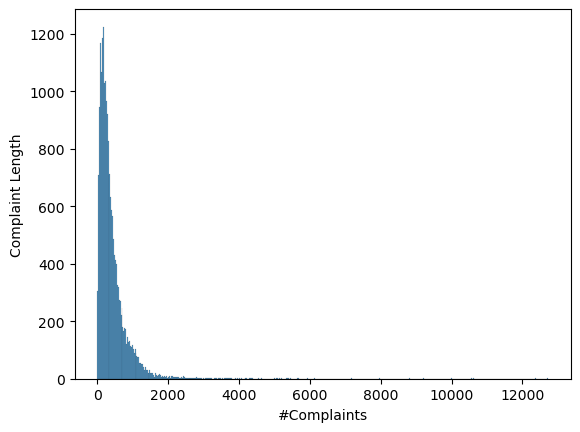

In [17]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint_POS_removed'].str.len()

sns.histplot(data=df_clean, x='complaint_length')
plt.xlabel('#Complaints')
plt.ylabel('Complaint Length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

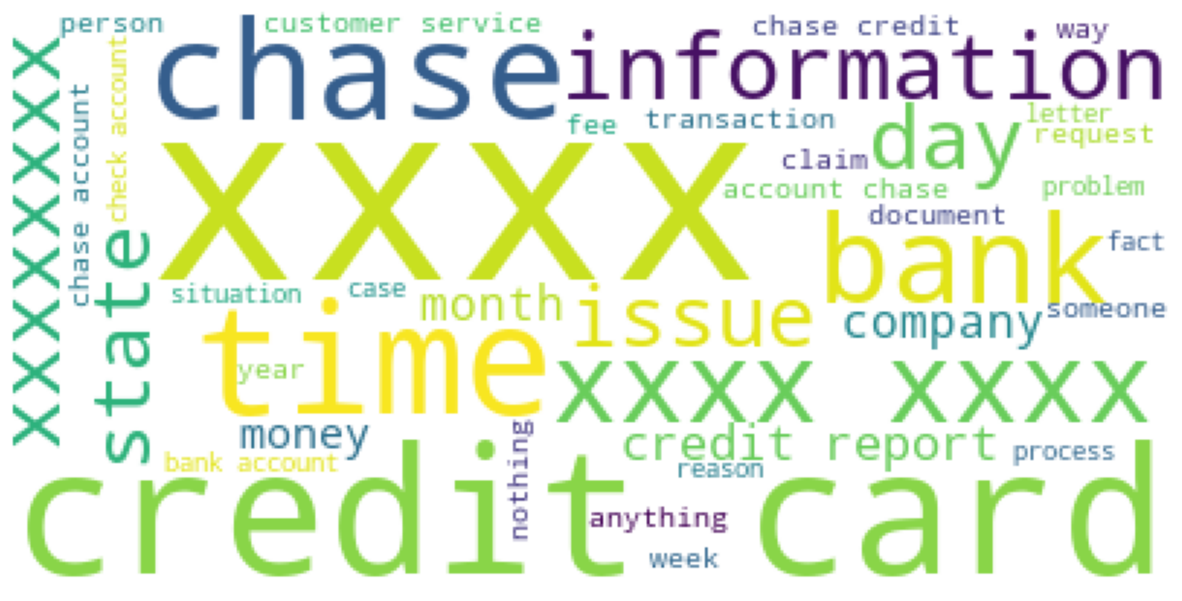

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=40, background_color='white').generate(' '.join(df_clean['complaint_POS_removed'].to_list()))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [19]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_ngrams(data, ngram=1, top=None):
    count_vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(data)
    bow = count_vec.transform(data)

    count_words = bow.sum(axis=0) 
    words_count = [(word, count_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]

    words_count =sorted(words_count, key = lambda x: x[1], reverse=True)
    return words_count[:top]

unigrams = get_ngrams(df_clean['Complaint_clean'], ngram=1, top=30)

In [21]:
#Print the top 10 words in the unigram frequency
unigrams[:10]

[('chase', 52499),
 ('xxxx', 47804),
 ('account', 46594),
 ('credit', 33449),
 ('card', 30171),
 ('bank', 21530),
 ('payment', 21139),
 ('time', 15982),
 ('charge', 14136),
 ('xxxxxxxx', 13475)]

In [22]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = get_ngrams(df_clean['Complaint_clean'], ngram=2, top=30)

In [23]:
#Print the top 10 words in the bigram frequency
bigrams[:10]

[('credit card', 12835),
 ('xxxx xxxx', 5232),
 ('credit report', 3912),
 ('customer service', 3053),
 ('account chase', 2908),
 ('chase credit', 2814),
 ('chase account', 2583),
 ('bank account', 2427),
 ('check account', 2280),
 ('account account', 2242)]

In [24]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = get_ngrams(df_clean['Complaint_clean'], ngram=3, top=30)

In [25]:
#Print the top 10 words in the trigram frequency
trigrams[:10]

[('chase credit card', 1884),
 ('credit card account', 1087),
 ('credit card company', 985),
 ('xxxx xxxx xxxx', 843),
 ('xxxx credit card', 806),
 ('credit card chase', 710),
 ('credit card credit', 511),
 ('inquiry credit report', 484),
 ('credit card xxxx', 432),
 ('account credit card', 413)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [26]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [27]:
#All masked texts has been removed
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,158,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,391,ticket offer ticket reward card information ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,222,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,669,credit card provider claim purchase protectio...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,725,risk consumer chase bank app chase year banki...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,553,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [28]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [29]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vectorizer.fit_transform(df_clean['Complaint_clean'])
X

<21072x6978 sparse matrix of type '<class 'numpy.float64'>'
	with 645490 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [30]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [31]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40,n_components=num_topics)

In [32]:
nmf_model.fit(X)
len(vectorizer.get_feature_names_out())

6978

In [33]:
nmf_model.components_.shape

(5, 6978)

In [34]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print('Topic #', index)
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]])

Topic # 0
['transaction', 'customer', 'transfer', 'number', 'business', 'checking', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']
Topic # 1
['reason', 'application', 'purchase', 'offer', 'interest', 'month', 'point', 'year', 'score', 'limit', 'account', 'balance', 'chase', 'credit', 'card']
Topic # 2
['statement', 'amount', 'property', 'balance', 'rate', 'year', 'time', 'interest', 'modification', 'month', 'home', 'chase', 'mortgage', 'loan', 'payment']
Topic # 3
['creditor', 'file', 'date', 'letter', 'score', 'theft', 'account', 'identity', 'debt', 'reporting', 'information', 'company', 'credit', 'inquiry', 'report']
Topic # 4
['call', 'time', 'refund', 'service', 'amount', 'email', 'purchase', 'fraud', 'fee', 'merchant', 'claim', 'chase', 'transaction', 'dispute', 'charge']


In [35]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_nums = nmf_model.transform(X).argmax(axis=1)
topic_nums

array([0, 1, 3, ..., 4, 1, 2], dtype=int64)

In [36]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_nums

In [37]:
df_clean.head()

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,158,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,3
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,391,ticket offer ticket reward card information ...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...,0


In [38]:
#Print the first 5 Complaint for each of the Topics
df_clean2=df_clean.groupby('Topic').head(5)
df_clean2.sort_values('Topic')

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,158,morning name stop bank cardmember service ask ...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,33,mishandle account chase auto,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,632,notice account debit card branch customer serv...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus xxxxxxxx term everythi...,130,account bank code bonus term everything accou...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,620,chase card decline catering order place brothe...,1
59,i currently have over xxxx chase ultimate rewa...,I currently have over xxxx chase ultimate rewa...,chase reward point month reward account bonus ...,504,chase reward point month reward account bonus ...,1
52,my roommate was stealing my chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver license money...,204,roommate chase debit card driver license money...,1
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...,1
50,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen company time share company nothing ref...,81,citizen company time share company nothing ref...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [39]:
#Create the dictionary of Topic names and Topics
Topic_names = {1 : 'Credit card / Prepaid card',
               0 : 'Bank account services',
               3 : 'Theft/Dispute reporting',
               4 : 'Mortgages/loans',
               2 : 'Others'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [40]:
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,158,morning name stop bank cardmember service ask ...,Bank account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...,Credit card / Prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,Theft/Dispute reporting
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,391,ticket offer ticket reward card information ...,Theft/Dispute reporting
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...,Bank account services
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,222,chase card customer decade solicitation credit...,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,669,credit card provider claim purchase protectio...,Mortgages/loans
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,725,risk consumer chase bank app chase year banki...,Mortgages/loans
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,553,credit yrs chase credit card chase freedom pro...,Credit card / Prepaid card


In [41]:
df_clean.shape

(21072, 6)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [42]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Credit card / Prepaid card':1,
               'Bank account services':0,
               'Theft/Dispute reporting':3,
               'Mortgages/loans':4,
               'Others':2}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [43]:
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,158,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,3
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,391,ticket offer ticket reward card information ...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...,0
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,222,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,669,credit card provider claim purchase protectio...,4
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,725,risk consumer chase bank app chase year banki...,4
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,553,credit yrs chase credit card chase freedom pro...,1


In [44]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint','Topic']]

In [45]:
training_data

,complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,3
11,on while trying to book a xxxx xxxx ticket ...,3
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,4
78310,i am not familiar with xxxx pay and did not un...,4
78311,i have had flawless credit for yrs ive had ch...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [46]:

#Write your code to get the Vector count
count_vectorizer = CountVectorizer()
count_vectorized_complaints = count_vectorizer.fit_transform(training_data['complaint'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
tfidf_complaints = tfidf_transformer.fit_transform(count_vectorized_complaints)


In [47]:
# Create test train split
X_train, X_test, Y_train, Y_test = train_test_split(tfidf_complaints, training_data['Topic'], test_size=0.25, random_state=99)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

###### 1. Logistic Regression

In [48]:
# Write your code here to build any 3 models and evaluate them using the required metrics
lr = LogisticRegression()
lr.fit(X_train, Y_train)
Y_train_pred_lr = lr.predict(X_train)
Y_test_pred_lr = lr.predict(X_test)

print('Train Accuracy Score=', accuracy_score(Y_train, Y_train_pred_lr))
print('Test Accuracy Score=', accuracy_score(Y_test, Y_test_pred_lr))


Train Accuracy Score= 0.9644393824348266
Test Accuracy Score= 0.9176157934700075


###### 2. Decision Tree

In [49]:
dt = DecisionTreeClassifier(random_state = 99)

In [50]:
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}
cv = GridSearchCV(dt, param_grid=params, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)
cv.fit(X_train, Y_train)
print("Best Score: ", cv.best_score_)
print("Best Hyperparameters: ", cv.best_params_)

Fitting 4 folds for each of 150 candidates, totalling 600 fits
Best Score:  0.7487344975955456
Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [51]:
best_dt = cv.best_estimator_
Y_train_pred_dt = best_dt.predict(X_train)
Y_test_pred_dt = best_dt.predict(X_test)

print('Train Accuracy Score=', accuracy_score(Y_train, Y_train_pred_dt))
print('Test Accuracy Score=', accuracy_score(Y_test, Y_test_pred_dt))


Train Accuracy Score= 0.8016957732219692
Test Accuracy Score= 0.7665148063781321


###### 3. Random Forest Classifier

In [52]:
rfc=RandomForestClassifier(random_state=99)

In [53]:
params = {'max_depth': [10,20,50],
          'min_samples_leaf': [2,3,5,10,15],
          'n_estimators': [100,200,500]
}
cv = HalvingRandomSearchCV(rfc, param_distributions=params, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)
cv.fit(X_train, Y_train)
print("Best Score: ", cv.best_score_)
print("Best Hyperparameters: ", cv.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 6
min_resources_: 40
max_resources_: 15804
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 45
n_resources: 40
Fitting 4 folds for each of 45 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 15
n_resources: 120
Fitting 4 folds for each of 15 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 5
n_resources: 360
Fitting 4 folds for each of 5 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 1080
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Best Score:  0.700925925925926
Best Hyperparameters:  {'n_estimators': 200, 'min_samples_leaf': 2, 'max_depth': 20}


In [54]:
best_rfc = cv.best_estimator_
Y_train_pred_rfc = best_rfc.predict(X_train)
Y_test_pred_rfc = best_rfc.predict(X_test)

print('Train Accuracy Score=', accuracy_score(Y_train, Y_train_pred_dt))
print('Test Accuracy Score=', accuracy_score(Y_test, Y_test_pred_dt))


Train Accuracy Score= 0.8016957732219692
Test Accuracy Score= 0.7665148063781321


| Algorithm | Training Accuracy | Test Accuracy |
|:--------:|:--------:|:--------:|
|  **Logistic Regression**   |  0.964   |  0.917   |
|  **Decision Tree Classifier**  |  0.801   |  0.767   |
|  **Random Forest Classifier**   |  0.801  |  0.767   |

**Conclusion**: Logistic Regression works best in this case with a training accuracy of 96.4% and a Test Accuracy of 91.7%.